# Building Recommendation Engines in Python Capstone project

In this project you are asked to build the Collaborative Filtering Model (CFM), for the MovieLens dataset to predict the preference/recommendation score for (user, movie) pairs.

We will use the `tensorflow.keras` framework for that purpose, and we will use the `Embedding` layers to build the users and movies latent factors.

We will use `pandas` for data loading and exploration. And `sklearn` for data preparation.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# MovieLens data
## Download

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-04-25 07:37:14--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   973KB/s    in 1.0s    

2020-04-25 07:37:16 (973 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [ ]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Load and Explore


In [ ]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
pd.crosstab(ratings.userId, ratings.movieId).head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


To get better idea, lets select the top 15 users and movies and crosstab them

In [ ]:
k = 15
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:k]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:k]

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)


movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


# Data preparation

- Movies with no rating from certain user are marked as NaN.
- User and movie Ids are unique values, and may have some gaps in the middle. We need to encode them as categorical variables to be able to deal with the Embedding layer. For that we use `sklearn.preprocessing.LabelEncoder`. Also, we need the number of user and movies to build the Embedding table rows.

In [ ]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings.userId.values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = user_enc.fit_transform(ratings.movieId.values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46


Prepare train and test data

In [ ]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

We use `train_test_split` from `sklearn` to randomly split the data into train and test data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90752, 2) (90752,)
(10084, 2) (10084,)


# Model

We will use the functional API of keras to code in the 2 input model

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,), name='user_id')
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='user_embedding_LUT')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# Movie embeddings
movie = layers.Input(shape=(1,), name='movie_id')
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='movie_embedding_LUT')(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Dot product
rating = layers.Dot(axes=1, name='similarity_measure')([user_emb, movie_emb])


# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
______________________________________________________________________________________________

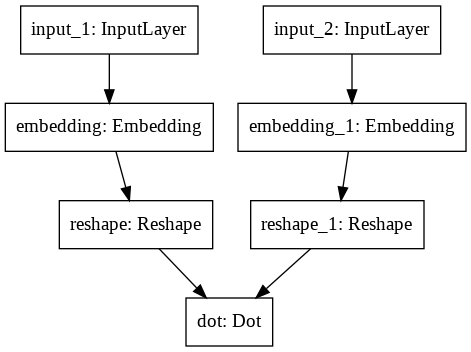

In [ ]:

plot_model(model, to_file='model.png')

Let's train the model.

We have two inputs to the model, `user_id` and `movie_id`, so we need to split that into separate arrray slices from X and y:


In [ ]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1418/1418 [==============================] - 6s 4ms/step - loss: 9.4012 - root_mean_squared_error: 3.0658 - val_loss: 3.2375 - val_root_mean_squared_error: 1.7988
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 2.0037 - root_mean_squared_error: 1.4127 - val_loss: 1.6325 - val_root_mean_squared_error: 1.2746
Epoch 3/5
1418/1418 [==============================] - 6s 4ms/step - loss: 1.1378 - root_mean_squared_error: 1.0614 - val_loss: 1.3547 - val_root_mean_squared_error: 1.1593
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.8715 - root_mean_squared_error: 0.9264 - val_loss: 1.2748 - val_root_mean_squared_error: 1.1234
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7371 - root_mean_squared_error: 0.8499 - val_loss: 1.2302 - val_root_mean_squared_error: 1.1027


__Scaling__

To help the model to scale the output within the required range, we pass the output of the Dot product to a sigmoid, which ranges from [0,1], then we scale that up to the range of `min_rating` to `max_rating`.


In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Dot product
rating = layers.Dot(axes=1)([user_emb, movie_emb])
rating = layers.Activation('sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        30500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        486200      input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1418/1418 [==============================] - 6s 4ms/step - loss: 1.3618 - root_mean_squared_error: 1.1667 - val_loss: 0.9253 - val_root_mean_squared_error: 0.9611
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7685 - root_mean_squared_error: 0.8751 - val_loss: 0.8017 - val_root_mean_squared_error: 0.8934
Epoch 3/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.5988 - root_mean_squared_error: 0.7711 - val_loss: 0.7719 - val_root_mean_squared_error: 0.8758
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.4767 - root_mean_squared_error: 0.6863 - val_loss: 0.7703 - val_root_mean_squared_error: 0.8740
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.3820 - root_mean_squared_error: 0.6123 - val_loss: 0.7787 - val_root_mean_squared_error: 0.8781


Scaling seems to work much better, and reaching the SoTA (actually beating it).

[Benchmark results](https://www.librec.net/release/v1.3/example.html) show lowest RMSE of 0.91 on the 100K dataset as we are using.

# Adding user and movie biases

The latent factors are dependedent on the dot product of users and movies ratings.

But there might be some _prior_ movie or user factor, that does not depend on the relation between the user and his ratings. Like for example, how much a movie is popular independent of the specific user rating, or how much a user likes movies, independent of his rating to a specific movie. Here where the bias role comes in.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        30500       input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 50)        486200      input_6[0][0]                    
____________________________________________________________________________________________

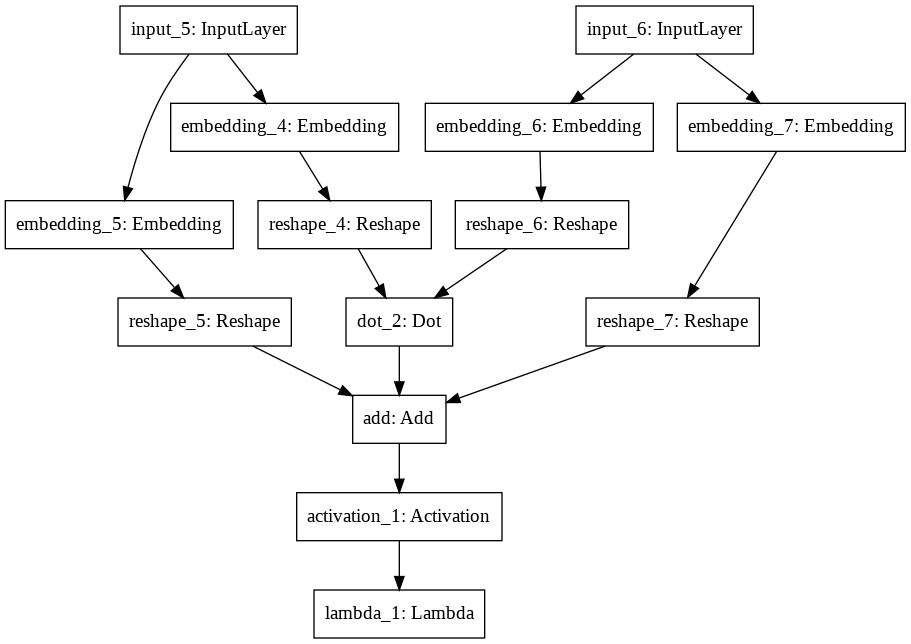

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Dot(axes=1)([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Activation('sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
print(model.summary())
plot_model(model, to_file='model.png')

In [ ]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1418/1418 [==============================] - 6s 4ms/step - loss: 1.2103 - root_mean_squared_error: 1.0999 - val_loss: 0.8615 - val_root_mean_squared_error: 0.9274
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7095 - root_mean_squared_error: 0.8411 - val_loss: 0.7534 - val_root_mean_squared_error: 0.8662
Epoch 3/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.5429 - root_mean_squared_error: 0.7344 - val_loss: 0.7304 - val_root_mean_squared_error: 0.8520
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.4163 - root_mean_squared_error: 0.6412 - val_loss: 0.7326 - val_root_mean_squared_error: 0.8525
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.3214 - root_mean_squared_error: 0.5612 - val_loss: 0.7467 - val_root_mean_squared_error: 0.8600


Adding user and movie biases give us extra good decrease in loss

# Deeper model

So far, we don't have any deep layers.

We could add some dense layers, on top of a concatenation of the two embeddings


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        30500       input_7[0][0]                    
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 50)        486200      input_8[0][0]                    
____________________________________________________________________________________________

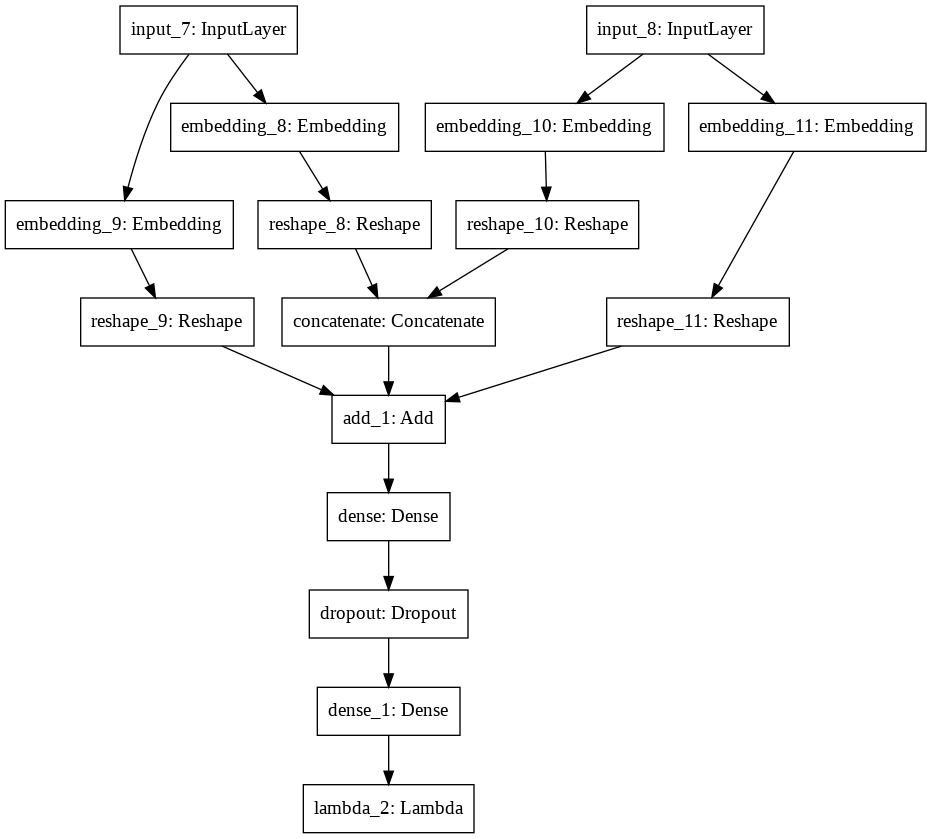

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate()([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dropout(0.5)(rating)
rating = layers.Dense(1, activation='sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
print(model.summary())
plot_model(model, to_file='model.png')

In [ ]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1418/1418 [==============================] - 6s 4ms/step - loss: 0.9272 - root_mean_squared_error: 0.9627 - val_loss: 0.7931 - val_root_mean_squared_error: 0.8903
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7681 - root_mean_squared_error: 0.8760 - val_loss: 0.7766 - val_root_mean_squared_error: 0.8807
Epoch 3/5
1418/1418 [==============================] - 6s 5ms/step - loss: 0.7294 - root_mean_squared_error: 0.8534 - val_loss: 0.7784 - val_root_mean_squared_error: 0.8816
Epoch 4/5
1418/1418 [==============================] - 6s 5ms/step - loss: 0.7151 - root_mean_squared_error: 0.8447 - val_loss: 0.7816 - val_root_mean_squared_error: 0.8832
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7025 - root_mean_squared_error: 0.8370 - val_loss: 0.7794 - val_root_mean_squared_error: 0.8817


A deeper model didnt help much, seems to be overfitting a bit. With more regularization and/or dropout could reach the same perfromance.

# Analysis

## Movie and User Bias

Use the best model

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 50)        30500       input_9[0][0]                    
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 50)        486200      input_10[0][0]                   
____________________________________________________________________________________________

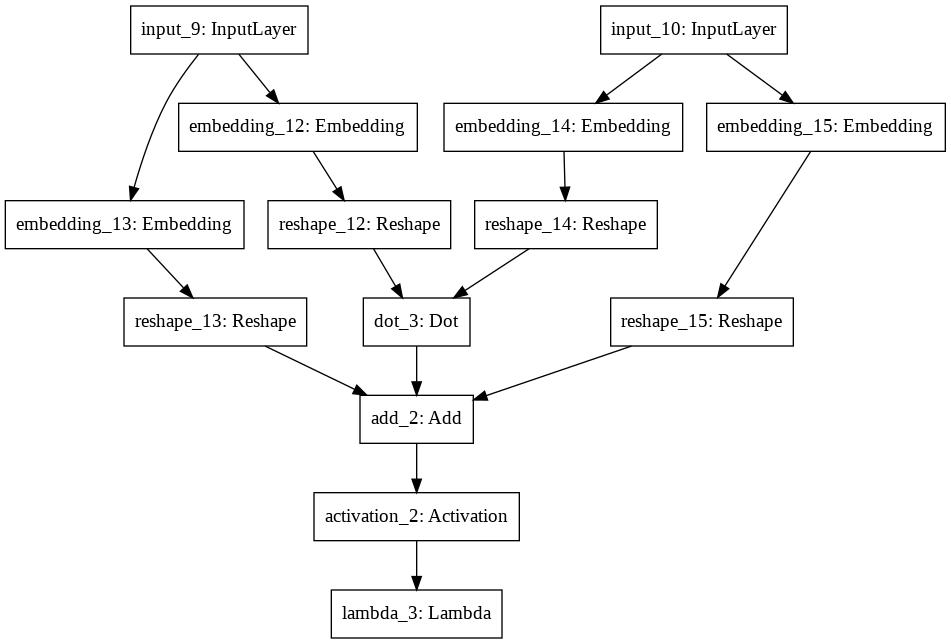

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Dot(axes=1)([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Activation('sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
print(model.summary())
plot_model(model, to_file='model.png')

In [ ]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1418/1418 [==============================] - 6s 4ms/step - loss: 1.2046 - root_mean_squared_error: 1.0973 - val_loss: 0.8576 - val_root_mean_squared_error: 0.9254
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7070 - root_mean_squared_error: 0.8396 - val_loss: 0.7510 - val_root_mean_squared_error: 0.8649
Epoch 3/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.5409 - root_mean_squared_error: 0.7330 - val_loss: 0.7302 - val_root_mean_squared_error: 0.8519
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.4166 - root_mean_squared_error: 0.6415 - val_loss: 0.7331 - val_root_mean_squared_error: 0.8528
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.3234 - root_mean_squared_error: 0.5630 - val_loss: 0.7478 - val_root_mean_squared_error: 0.8606


# Analysis

How popular is a certain movie, independent of the user preference?

In [ ]:
movie_bias_model = models.Model(movie, movie_bias)
movie_bias_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 1, 1)              9724      
_________________________________________________________________
reshape_15 (Reshape)         (None, 1)                 0         
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________


Let's get the top 2000 movies.

In [ ]:
k = 2000


g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:k]



In [ ]:
top_movies

movieId
356      329
318      317
296      307
593      279
2571     278
        ... 
1273      11
46335     11
2796      11
3004      11
42723     11
Name: rating, Length: 2000, dtype: int64

In [ ]:
top_movies.index # movies

Int64Index([  356,   318,   296,   593,  2571,   260,   480,   110,   589,
              527,
            ...
              599, 64983,   694, 64716,  2822,  1273, 46335,  2796,  3004,
            42723],
           dtype='int64', name='movieId', length=2000)

In [ ]:
top_movies.values # ratings

array([329, 317, 307, ...,  11,  11,  11])

In [ ]:
top_movies = list(top_movies.index)

In [ ]:
def movie2title(movies_lst):
  return movies[movies.movieId.isin(movies_lst)]


In [ ]:
movie2title(top_movies)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
...,...,...,...
9571,174055,Dunkirk (2017),Action|Drama|Thriller|War
9604,176371,Blade Runner 2049 (2017),Sci-Fi
9621,177765,Coco (2017),Adventure|Animation|Children
9645,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi


In [ ]:
len(movies.movieId.unique())

9742

Now, to get the movie bias, we cannot just feed its ID, because we have to pass it to the labelencoder first.



In [ ]:
sel_movie = 0

#movie_in = ratings[ratings.movieId == top_movies[sel_movie]]['movie'].values[0]
movie_in = user_enc.transform(np.expand_dims(top_movies[sel_movie], 0))
movie_in

array([314])

In [ ]:
mb = movie_bias_model.predict(movie_in, 0)

In [ ]:
mb

array([[0.5017027]], dtype=float32)

If we want that for all the top 2000 movies

In [ ]:
def get_top_k_movies_code(k):
  g = ratings.groupby('movieId')['rating'].count()
  top_movies = g.sort_values(ascending=False)[:k]
  top_movies = list(top_movies.index)
  return user_enc.transform(top_movies), top_movies

In [ ]:
movies_in, moviesIds = get_top_k_movies_code(k=2000)

In [ ]:
movies_in

array([ 314,  277,  257, ..., 2101, 2261, 6090])

In [ ]:
movies_titles = movie2title(moviesIds)['title']

In [ ]:
movies_titles

0                         Toy Story (1995)
1                           Jumanji (1995)
2                  Grumpier Old Men (1995)
4       Father of the Bride Part II (1995)
5                              Heat (1995)
                       ...                
9571                        Dunkirk (2017)
9604              Blade Runner 2049 (2017)
9621                           Coco (2017)
9645       Star Wars: The Last Jedi (2017)
9709                     Deadpool 2 (2018)
Name: title, Length: 2000, dtype: object

In [ ]:

mbs = movie_bias_model.predict(movies_in)

In [ ]:
len(mbs)

2000

In [ ]:
mbs

array([[ 0.5017027 ],
       [ 0.56087595],
       [ 0.2621239 ],
       ...,
       [ 0.02886072],
       [-0.06316119],
       [-0.01090846]], dtype=float32)

In [ ]:
movie_bias_df = pd.DataFrame(movies_titles)
movie_bias_df['bias'] = mbs
movie_bias_df.head()

,title,bias
0,Toy Story (1995),0.501703
1,Jumanji (1995),0.560876
2,Grumpier Old Men (1995),0.262124
4,Father of the Bride Part II (1995),0.207829
5,Heat (1995),0.211232


In [ ]:
movie_bias_df.sort_values('bias', ascending=False)

,title,bias
1,Jumanji (1995),0.560876
0,Toy Story (1995),0.501703
198,Eat Drink Man Woman (Yin shi nan nu) (1994),0.391028
6,Sabrina (1995),0.363988
2008,"Thirteenth Floor, The (1999)",0.356012
...,...,...
3915,Signs (2002),-0.239535
6332,Flags of Our Fathers (2006),-0.242444
1493,Bambi (1942),-0.254248
6642,"Bucket List, The (2007)",-0.258685


Notice the difference between the ranking based on movie bias from the model, and those based on the averating _rating_ column in MovieLens.

The movie bias is a _normalization_ over all the _users_, instead of just taking the average ratings.

# Movie embeddings

In [ ]:
movie_emb_model = models.Model(movie, movie_emb)
movie_emb_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 1, 50)             486200    
_________________________________________________________________
reshape_14 (Reshape)         (None, 50)                0         
Total params: 486,200
Trainable params: 486,200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
movies_in, moviesIds = get_top_k_movies_code(k=2000)
movies_titles = movie2title(moviesIds)['title']

In [ ]:

top_movies_embs = movie_emb_model.predict(movies_in)

In [ ]:
top_movies_embs.shape

(2000, 50)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
result = pca.fit_transform(top_movies_embs)

Let's try tpo figure out what are the latent factors:

In [ ]:
movie_latent_factors = pd.DataFrame(movies_titles)
movie_latent_factors['factor_0'] = result[:,0]
movie_latent_factors['factor_1'] = result[:,1]
movie_latent_factors['factor_2'] = result[:,2]
movie_latent_factors

,title,factor_0,factor_1,factor_2
0,Toy Story (1995),-0.278005,0.751162,0.313859
1,Jumanji (1995),-0.984841,0.581550,0.377484
2,Grumpier Old Men (1995),-1.279781,-0.244140,-0.453658
4,Father of the Bride Part II (1995),-0.816554,0.545223,0.338718
5,Heat (1995),-0.752872,0.717386,-0.369139
...,...,...,...,...
9571,Dunkirk (2017),-0.639877,-0.249592,-0.100562
9604,Blade Runner 2049 (2017),0.766840,-0.636974,0.284885
9621,Coco (2017),0.354498,-0.083398,0.143390
9645,Star Wars: The Last Jedi (2017),1.037251,0.186945,-0.272679


Let's sort by the factors:

In [ ]:
movie_latent_factors.sort_values('factor_0')

,title,factor_0,factor_1,factor_2
2,Grumpier Old Men (1995),-1.279781,-0.244140,-0.453658
24,Leaving Las Vegas (1995),-1.226336,-0.033326,0.202144
134,Crimson Tide (1995),-1.151981,-0.268237,0.227814
61,Friday (1995),-1.081181,-0.283692,-0.473304
777,"20,000 Leagues Under the Sea (1954)",-1.046890,-0.085251,0.516375
...,...,...,...,...
5923,Bewitched (2005),1.161033,-0.146358,0.087674
8691,Deadpool (2016),1.211176,-0.771655,0.063774
2224,Home Alone 2: Lost in New York (1992),1.321183,-0.430576,-0.046365
7888,Prometheus (2012),1.328679,-0.168954,0.467732


Looks like at one end, looking on social movies. On the other, more of recent and Sci-Fi.

In [ ]:
movie_latent_factors.sort_values('factor_1')

,title,factor_0,factor_1,factor_2
3145,Spy Kids (2001),0.755992,-0.840144,0.098075
8583,The Theory of Everything (2014),0.628552,-0.815070,-0.052537
5989,Family Guy Presents Stewie Griffin: The Untold...,-0.364555,-0.805046,-0.206511
3890,Road to Perdition (2002),0.915515,-0.790918,0.131461
1434,Chariots of Fire (1981),0.381417,-0.777362,0.029891
...,...,...,...,...
9,GoldenEye (1995),-0.308683,0.728441,0.115452
0,Toy Story (1995),-0.278005,0.751162,0.313859
19,Money Train (1995),0.653133,0.756806,0.246526
6221,Pirates of the Caribbean: Dead Man's Chest (2006),0.348107,0.795926,0.483415


In [ ]:
movie_latent_factors.sort_values('factor_2')

,title,factor_0,factor_1,factor_2
1347,Mercury Rising (1998),0.332178,0.076090,-0.702017
117,"Brothers McMullen, The (1995)",-0.589981,0.178241,-0.691810
946,"Graduate, The (1967)",-0.338809,-0.401788,-0.658833
199,Exotica (1994),-0.647799,-0.192046,-0.658026
2044,Mystery Men (1999),0.481943,0.023822,-0.636760
...,...,...,...,...
830,Weekend at Bernie's (1989),0.729404,0.545231,0.678696
630,Phenomenon (1996),0.583151,0.238616,0.682040
1056,Star Trek V: The Final Frontier (1989),-0.055650,0.001553,0.704540
598,Spy Hard (1996),-0.570099,0.124406,0.772339


# Visualization

We will work on just 20, for visualization purposes

In [ ]:
movies_in, moviesIds = get_top_k_movies_code(k=10)
movies_titles = movie2title(moviesIds)['title']
top_movies_embs = movie_emb_model.predict(movies_in)

To be able to visualize, we should get to 2D

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(top_movies_embs)

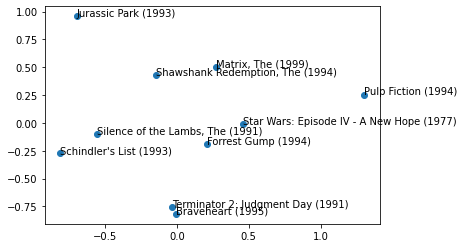

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(result[:, 0], result[:, 1])
titles = list(movies_titles)
for i, title in enumerate(titles):
  plt.annotate(title, xy=(result[i, 0], result[i, 1]))
plt.show()

Using tSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
result = TSNE(random_state=123).fit_transform(top_movies_embs)
result.shape

(10, 2)

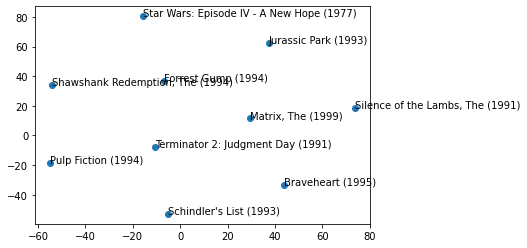

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(result[:, 0], result[:, 1])
titles = list(movies_titles)
for i, title in enumerate(titles):
  plt.annotate(title, xy=(result[i, 0], result[i, 1]))
plt.show()